In [50]:
.libPaths(c(.libPaths(),'/home/sayantan/R/x86_64-pc-linux-gnu-library/3.0',
            '/home/sayantan/R/x86_64-pc-linux-gnu-library/3.4',
           '/usr/lib/R/library'))
library(xts)
library(data.table)
library(ggplot2)

In [51]:
air_visit_data <- fread('./input/air_visit_data.csv')
date_info <- fread('./input/date_info.csv')
air_store_info <- fread('./input/air_store_info.csv')

In [52]:
air_visit_data <- merge(air_visit_data,air_store_info,by='air_store_id')
air_visit_data <- merge(air_visit_data,date_info,by.x='visit_date',by.y='calendar_date')
air_visit_data$visit_date <- as.Date(air_visit_data$visit_date,'%Y-%m-%d')
air_visit_data$golden_diff <- as.numeric(air_visit_data$visit_date - as.Date('2016-04-29','%Y-%m-%d'))
air_visit_data$golden_diff <- floor((air_visit_data$golden_diff + 700) / 7.0) - 100
air_visit_data$city <- substr(air_visit_data$air_area_name,1,5)

golden2 <- air_visit_data[,.(visitors=sum(visitors),restaurant_days=.N),by=.(air_genre_name,golden_diff)]
golden2$visitors_per_day <- 1.0 * golden2$visitors / golden2$restaurant_days
golden2 <- golden2[golden2$golden_diff <= 5 & golden2$golden_diff >= -5,]
t1 <- aggregate(restaurant_days ~ air_genre_name, data=golden2, sum)
t1 <- t1[order(t1$restaurant_days, decreasing=TRUE),]
golden2$air_genre_name_days <- factor(golden2$air_genre_name, levels = t1$air_genre_name)

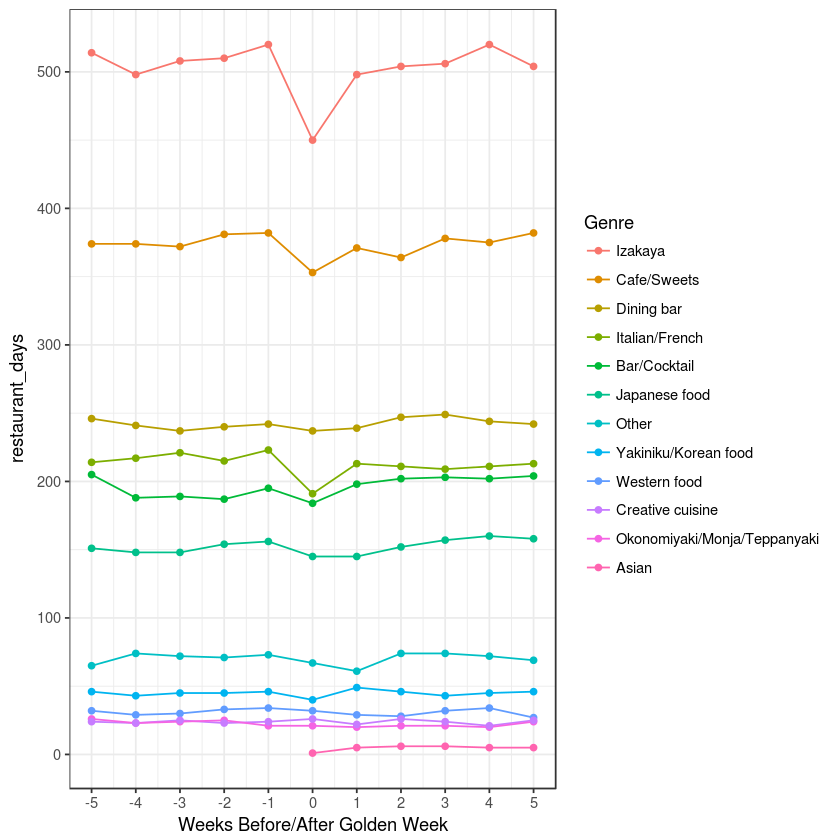

In [53]:
ggplot(golden2, aes(x=golden_diff, y=restaurant_days, colour=air_genre_name_days, group=air_genre_name_days)) + 
geom_line() + 
geom_point() + 
scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + 
scale_colour_discrete(name = "Genre")

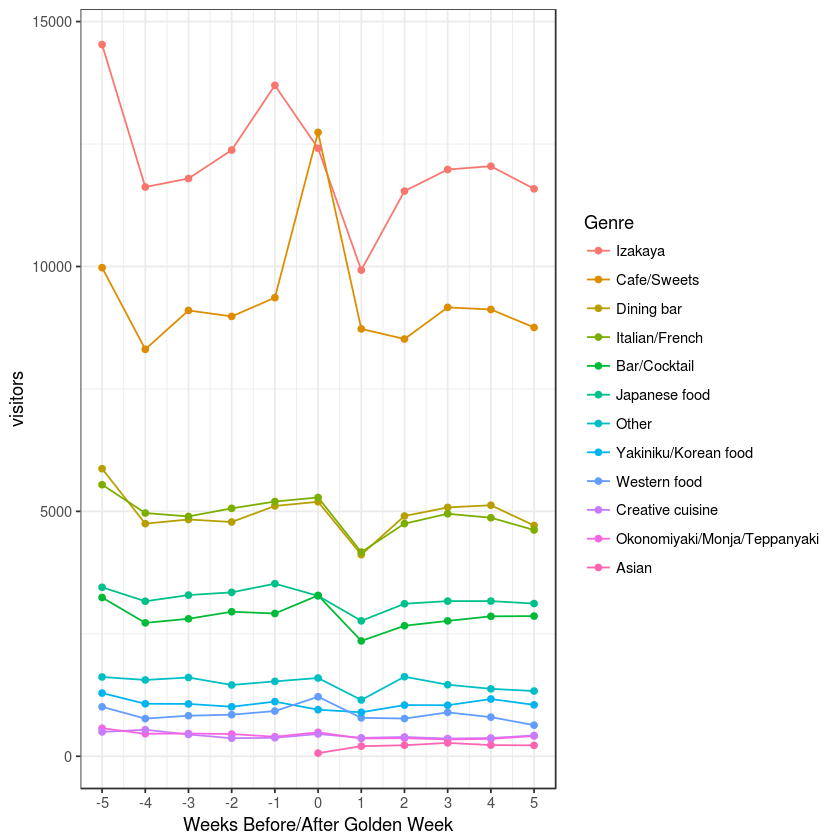

In [54]:
ggplot(golden2, aes(x=golden_diff, y=visitors, colour=air_genre_name_days, group=air_genre_name_days)) + geom_line() + geom_point() + scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + scale_colour_discrete(name = "Genre")

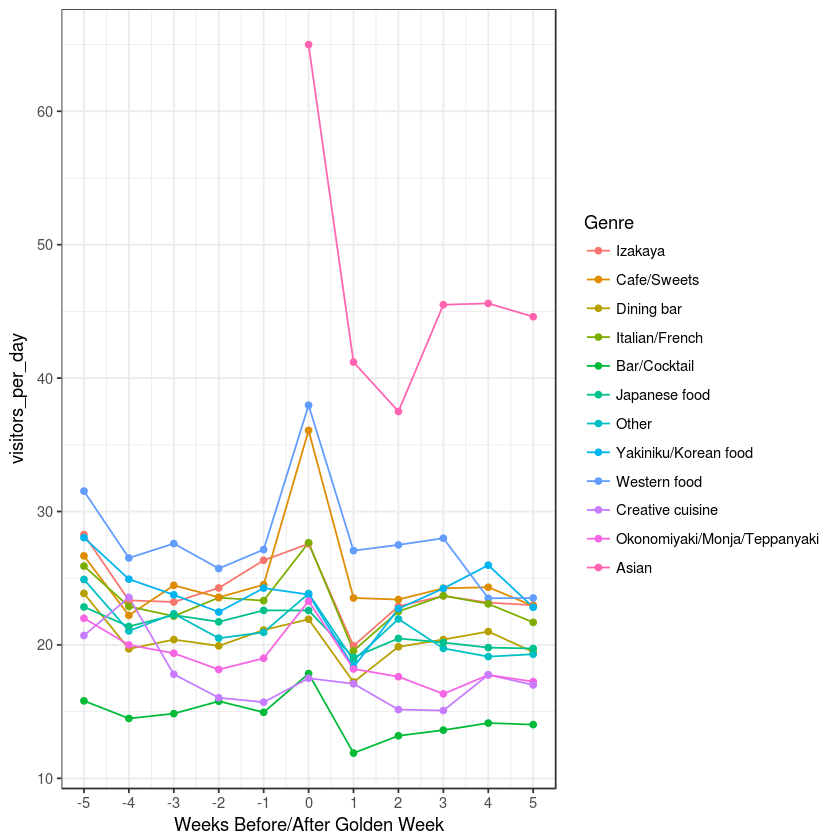

In [55]:
ggplot(golden2, aes(x=golden_diff, y=visitors_per_day, colour=air_genre_name_days, group=air_genre_name_days)) + geom_line() + geom_point() + scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + scale_colour_discrete(name = "Genre")

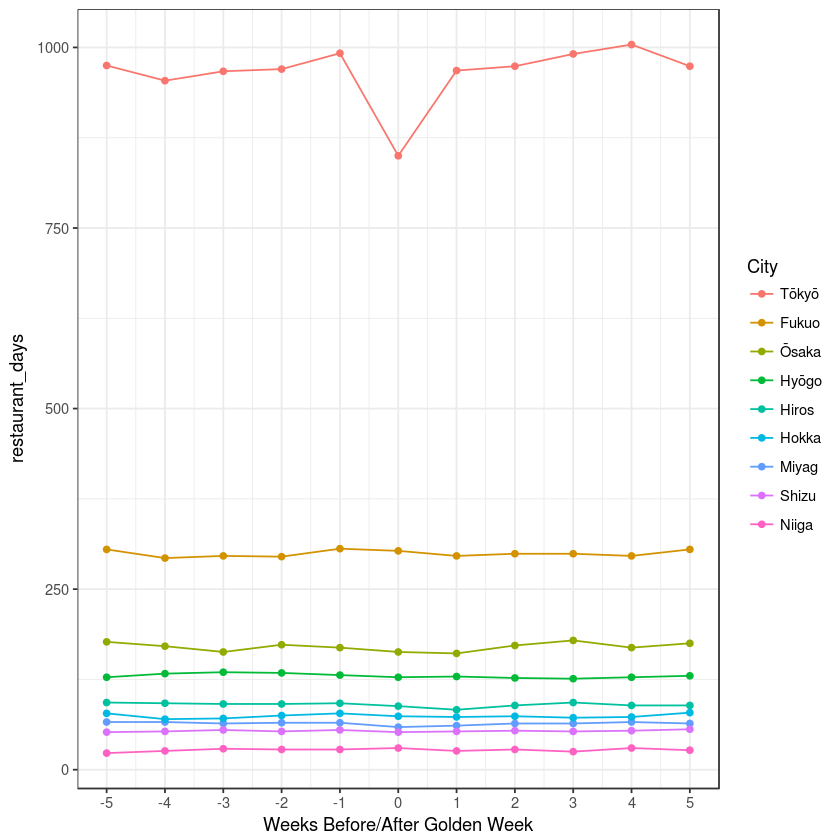

In [56]:
golden2 <- air_visit_data[,.(visitors=sum(visitors),restaurant_days=.N),by=.(city,golden_diff)]
golden2$visitors_per_day <- 1.0 * golden2$visitors / golden2$restaurant_days
golden2 <- golden2[golden2$golden_diff <= 5 & golden2$golden_diff >= -5,]
t1 <- aggregate(restaurant_days ~ city, data=golden2, sum)
t1 <- t1[order(t1$restaurant_days, decreasing=TRUE),]
golden2$city_days <- factor(golden2$city, levels = t1$city)

ggplot(golden2, aes(x=golden_diff, y=restaurant_days, colour=city_days, group=city_days)) + geom_line() + geom_point() + scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + scale_colour_discrete(name = "City")

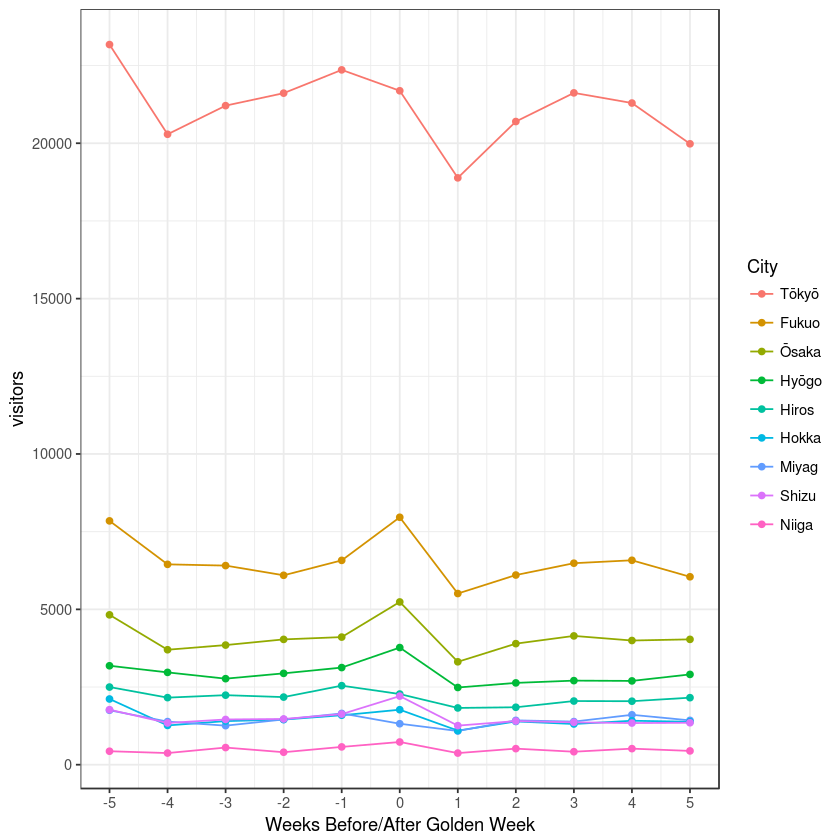

In [57]:
ggplot(golden2, aes(x=golden_diff, y=visitors, colour=city_days, group=city_days)) + geom_line() + geom_point() + scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + scale_colour_discrete(name = "City")

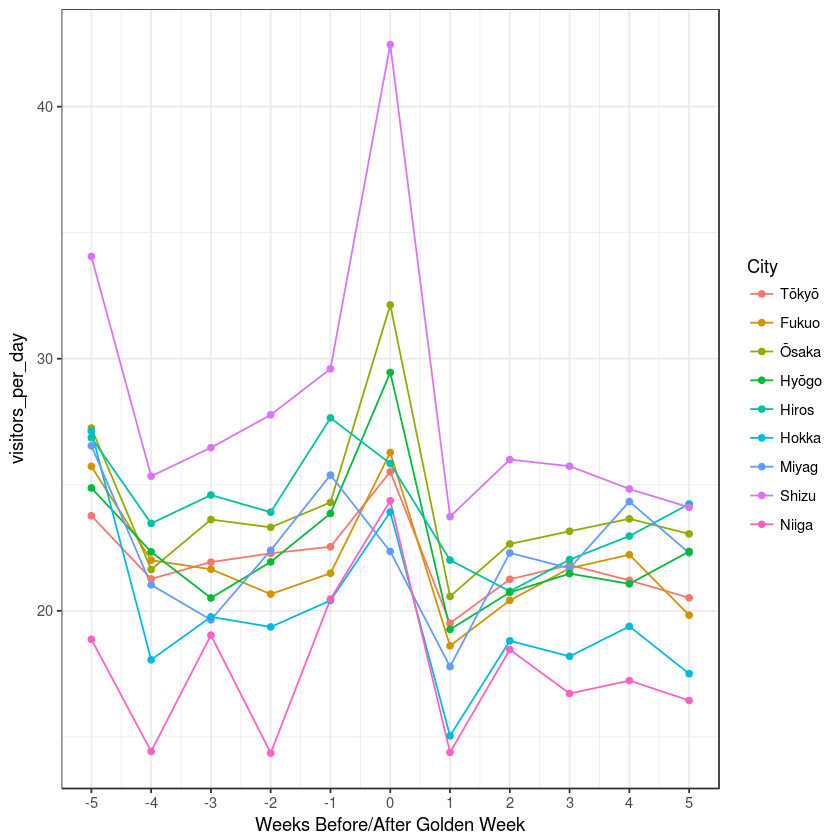

In [58]:
ggplot(golden2, aes(x=golden_diff, y=visitors_per_day, colour=city_days, group=city_days)) + geom_line() + geom_point() + scale_x_continuous(name='Weeks Before/After Golden Week',breaks = c(-5,-4,-3,-2,-1,0,1,2,3,4,5)) + scale_colour_discrete(name = "City")

In [59]:
library(data.table)
library(magrittr)
library(ggplot2)
library(lubridate)
library(xts)
library(forecast)
library(DT)
library(gridExtra)
library(leaflet)
library(htmltools)
library(mapdata)
library(maptools)
library(sp)

theme_set(theme_bw())

In [60]:
.libPaths()

[1] "/home/sayantan/anaconda2/lib/R/library"          
[2] "/home/sayantan/R/x86_64-pc-linux-gnu-library/3.0"
[3] "/home/sayantan/R/x86_64-pc-linux-gnu-library/3.4"
[4] "/usr/lib/R/library"

In [61]:
# Import
visits <- fread('./input/air_visit_data.csv')
air_res <- fread('./input/air_reserve.csv')
hpg_res <- fread('./input/hpg_reserve.csv')
dates <- fread('./input/date_info.csv')
hpg_store <- fread('./input/hpg_store_info.csv')
air_store <- fread('./input/air_store_info.csv')
store_id_rel <- fread('./input/store_id_relation.csv')

In [62]:
files <- list(visits, air_res, hpg_res, dates, hpg_store, air_store, store_id_rel)

myPlot <- data.frame(
    File = c('visits', 'air_res', 'hpg_res', 'dates', 'hpg_store', 'air_store', 'store_id_rel'),
    Nrows = sapply(files, nrow),
    Ncols = sapply(files, ncol),
    Size = sapply(files, function(x) { format(object.size(x), units = 'Mb')})
) 

myPlot 

File,Nrows,Ncols,Size
visits,252108,3,4.9 Mb
air_res,92378,4,3.3 Mb
hpg_res,2000320,4,55.8 Mb
dates,517,3,0 Mb
hpg_store,4690,5,0.5 Mb
air_store,829,5,0.1 Mb
store_id_rel,150,2,0 Mb


In [63]:
summary(visits)

 air_store_id        visit_date           visitors     
 Length:252108      Length:252108      Min.   :  1.00  
 Class :character   Class :character   1st Qu.:  9.00  
 Mode  :character   Mode  :character   Median : 17.00  
                                       Mean   : 20.97  
                                       3rd Qu.: 29.00  
                                       Max.   :877.00  

air_store_id,visit_date,visitors,total_visits
air_ba937bf13d40fb24,2016-01-13,25,4848
air_ba937bf13d40fb24,2016-01-14,32,5269
air_ba937bf13d40fb24,2016-01-15,29,6817
air_ba937bf13d40fb24,2016-01-16,22,7552
air_ba937bf13d40fb24,2016-01-18,6,3274
air_ba937bf13d40fb24,2016-01-19,9,4412


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


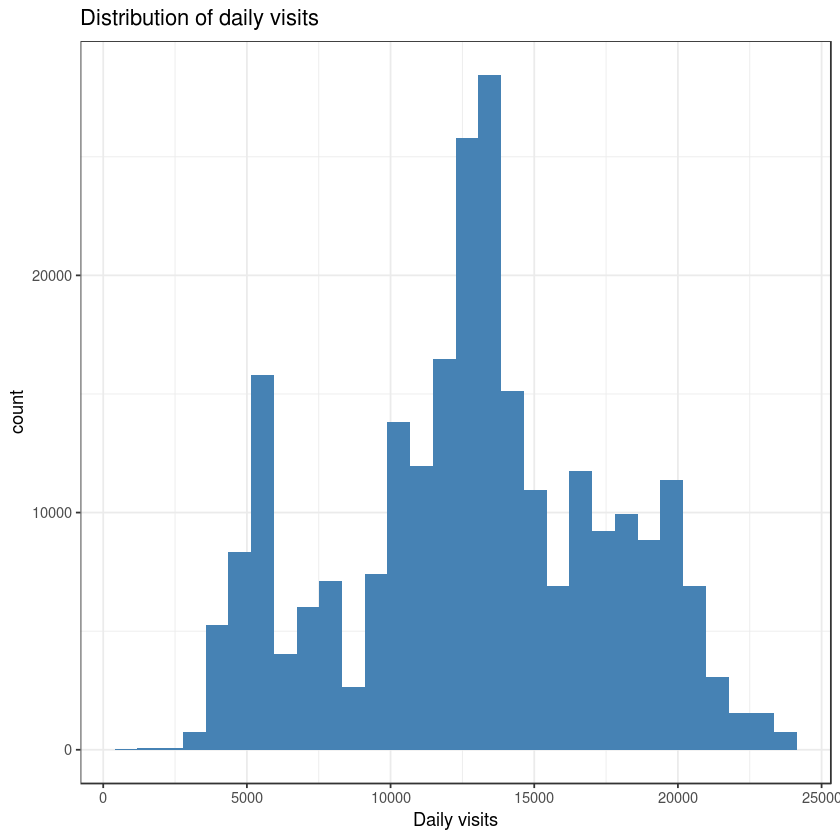

In [64]:
visits[, total_visits := sum(visitors), by = visit_date] 

head(visits)

ggplot(visits, aes(x = total_visits)) +
geom_histogram(fill = 'steelblue') +
labs(x = 'Daily visits', title = 'Distribution of daily visits')

In [65]:
visits[, visit_date := as.Date(visit_date)]

holidays <- dates[holiday_flg == 1, ]
holidays[, calendar_date := as.Date(calendar_date)]


In [66]:
p1 <- visits[, total_visit := sum(visitors), by = visit_date]

p1 <- ggplot(p1, aes(x = visit_date, y = total_visit)) + 
    geom_line(color = 'steelblue')+ 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    scale_x_date(date_breaks = "1 month") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    labs(x = '', y = 'Total visits', title = 'Visits by day (with holidays)')

In [67]:
p2 <- visits[order(wday(visit_date)), .(mean_visits = mean(visitors)), by = weekdays(visit_date)] 

p2 <- ggplot(p2,aes(x = reorder(weekdays, seq(1,7)), y = mean_visits)) + 
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = "Mean visits", title = "Average visits by day of week")


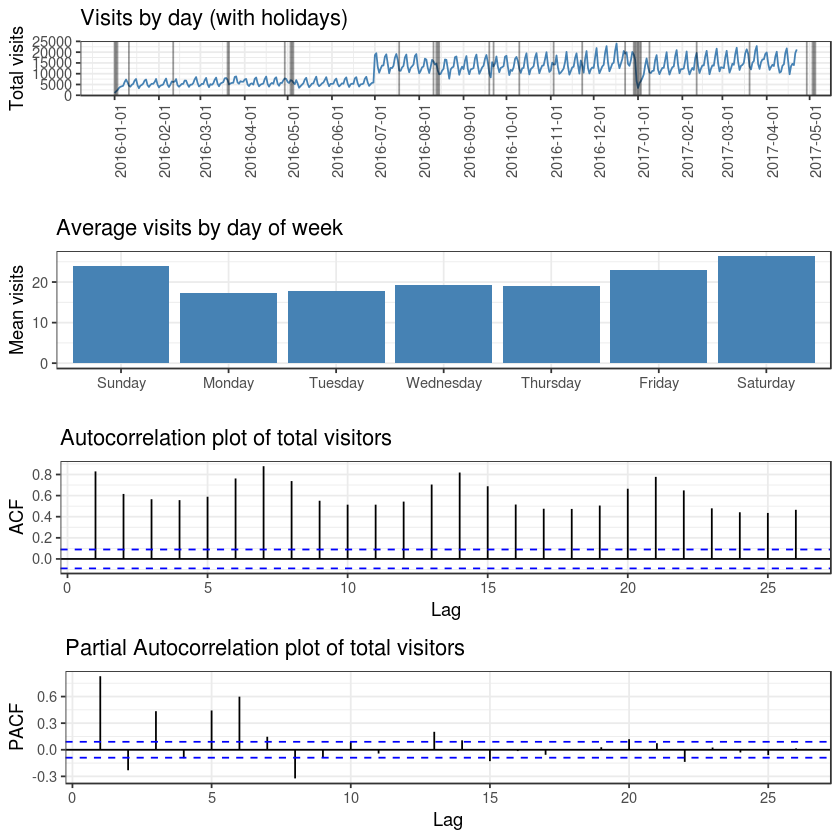

In [68]:
p3 <- as.xts(visits[, .(total_visitors = sum(visitors)), by = visit_date])

p3 <- ggAcf(p3) +
    labs(title = 'Autocorrelation plot of total visitors')

p4 <- as.xts(visits[, .(total_visitors = sum(visitors)), by = visit_date] )
    #as.xts() %>% 
p4 <- ggPacf(p4) +
    labs(title = 'Partial Autocorrelation plot of total visitors')
    

    
grid.arrange(p1, p2, p3, p4, nrow = 4)


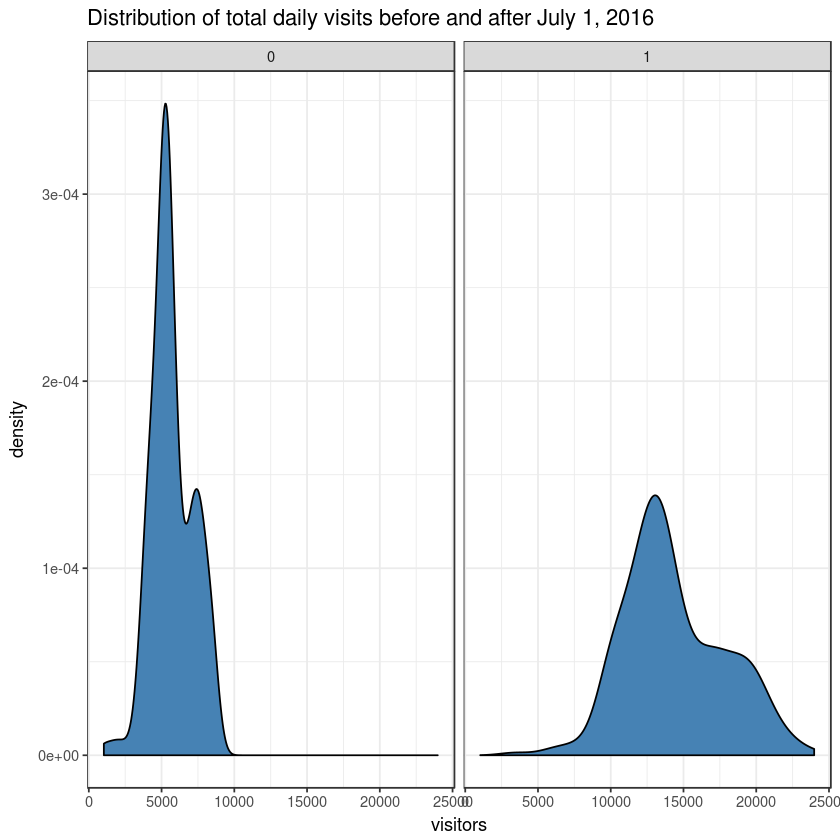

In [69]:
p1 = visits[, .(visitors = sum(visitors), s = ifelse(visit_date < as.Date('2016-07-01'), 0, 1)), by = visit_date] 
    ggplot(data =p1, aes(x = visitors)) + 
    geom_density(fill = 'steelblue') +
    facet_grid(~s) + 
    labs(title = 'Distribution of total daily visits before and after July 1, 2016')

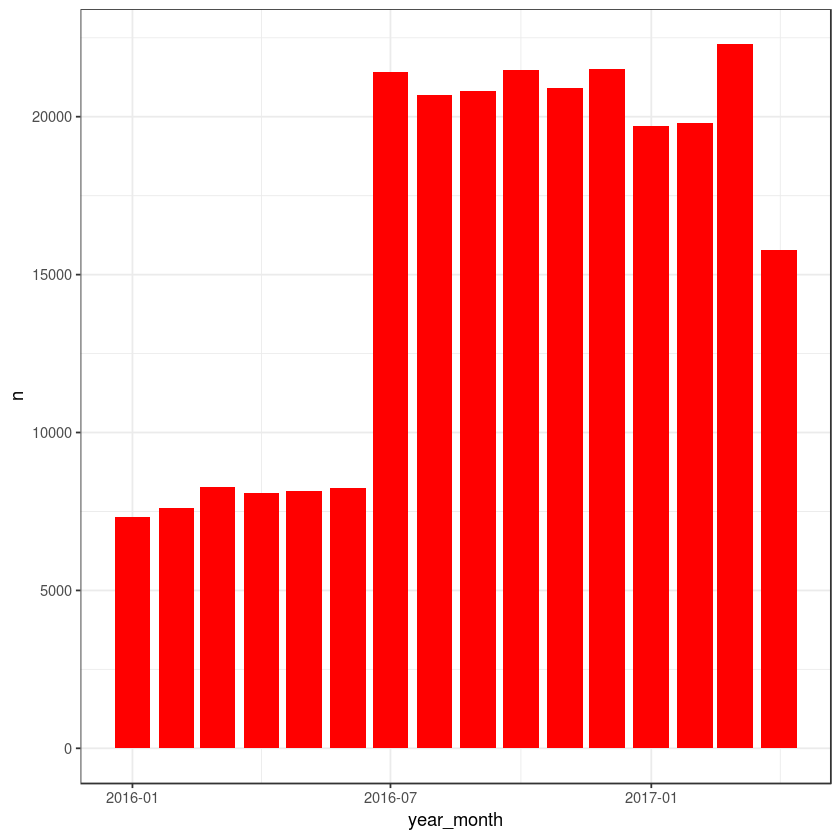

In [70]:
# Monthly visit
library(dplyr)
library(tidyr)
tmp <- visits %>% mutate(year_month = make_date(year=year(visit_date),month=month(visit_date)))
tmp %>% 
  group_by(year_month) %>% count() %>% 
  ggplot(aes(x=year_month,y=n)) +
  geom_bar(stat="identity", fill="red")

In [71]:
# Reservations
summary(air_res)

 air_store_id       visit_datetime     reserve_datetime   reserve_visitors 
 Length:92378       Length:92378       Length:92378       Min.   :  1.000  
 Class :character   Class :character   Class :character   1st Qu.:  2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  3.000  
                                                          Mean   :  4.482  
                                                          3rd Qu.:  5.000  
                                                          Max.   :100.000  

In [72]:
summary(hpg_res)

 hpg_store_id       visit_datetime     reserve_datetime   reserve_visitors 
 Length:2000320     Length:2000320     Length:2000320     Min.   :  1.000  
 Class :character   Class :character   Class :character   1st Qu.:  2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  3.000  
                                                          Mean   :  5.074  
                                                          3rd Qu.:  6.000  
                                                          Max.   :100.000  

In [73]:
# convert time columns to datetime
dt_cols <- c('visit_datetime', 'reserve_datetime')

air_res[, (dt_cols) := lapply(.SD, as_datetime), .SDcols = dt_cols]
hpg_res[, (dt_cols) := lapply(.SD, as_datetime), .SDcols = dt_cols]

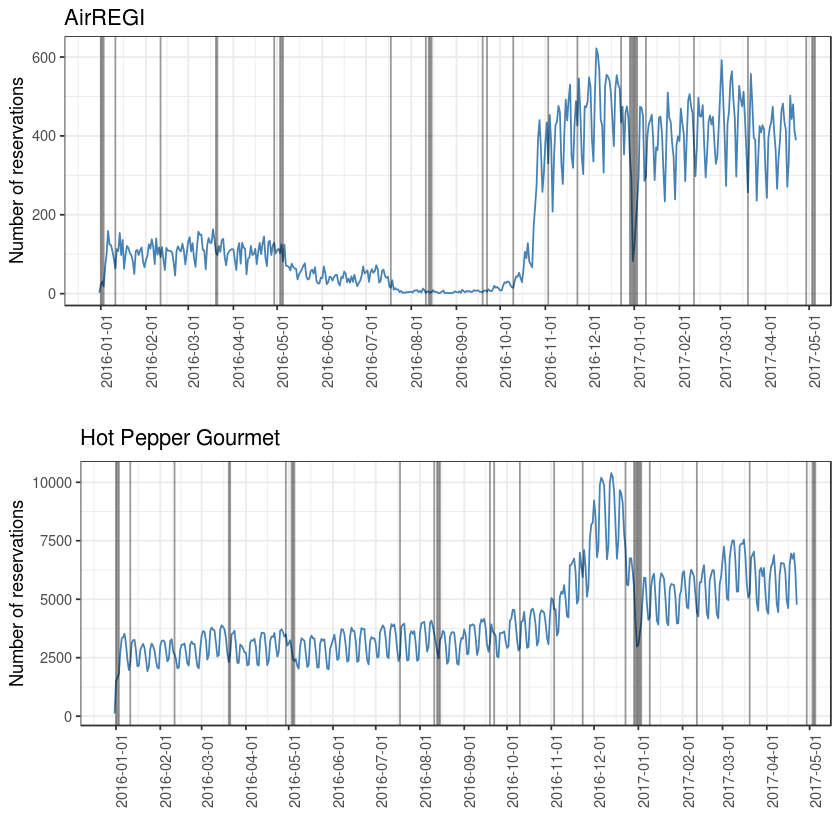

In [74]:
p1 <- air_res[, .(number_reservations = .N), by = .(date = as.Date(reserve_datetime))] 

p1 <- ggplot(data = p1, aes(x = date, y = number_reservations)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    scale_x_date(date_breaks = "1 month") + 
    labs(x = '', y = 'Number of reservations', title = 'AirREGI') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

p2 <- hpg_res[, .(number_reservations = .N), by = .(date = as.Date(reserve_datetime))] 

p2 <- ggplot(data = p2, aes(x = date, y = number_reservations)) + 
    geom_line(color = 'steelblue') +
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    scale_x_date(date_breaks = "1 month") + 
    labs(x = '', y = 'Number of reservations', title = 'Hot Pepper Gourmet') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

grid.arrange(p1, p2)

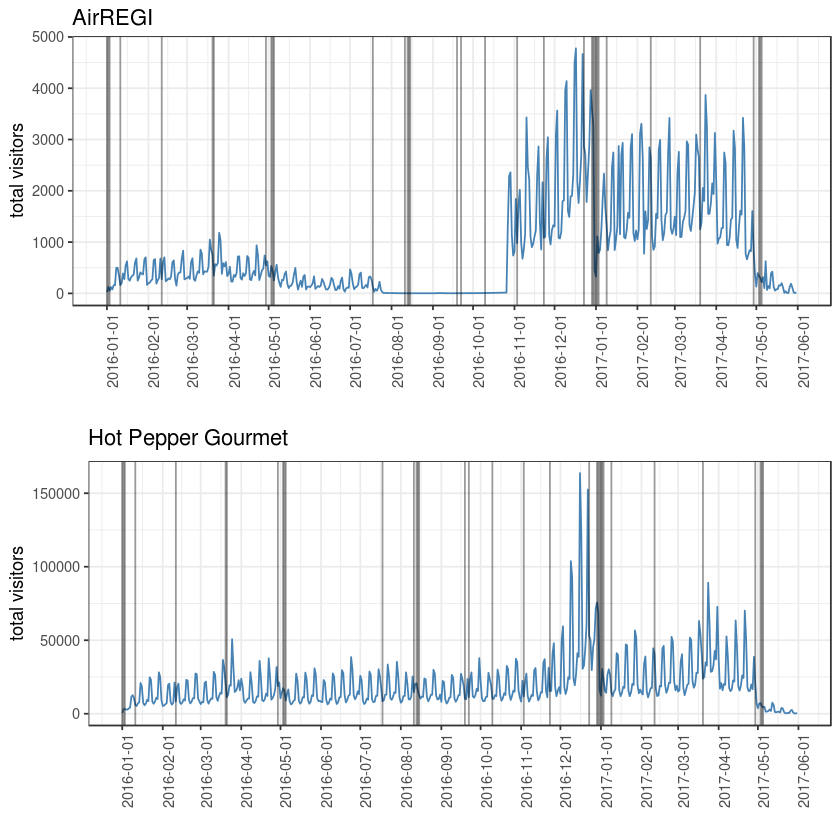

In [75]:
p1 <- air_res[, .(total_visitors = sum(reserve_visitors)), by = .(date = as.Date(visit_datetime))] 


p1 <-  ggplot(data = p1, aes(x = date, y = total_visitors)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    scale_x_date(date_breaks = "1 month") + 
    labs(x = '', y = 'total visitors', title = 'AirREGI') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

p2 <- hpg_res[, .(total_visitors = sum(reserve_visitors)), by = .(date = as.Date(visit_datetime))]
p2 <-  ggplot(data = p2, aes(x = date, y = total_visitors)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    scale_x_date(date_breaks = "1 month") + 
    labs(x = '', y = 'total visitors', title = 'Hot Pepper Gourmet') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

grid.arrange(p1, p2)

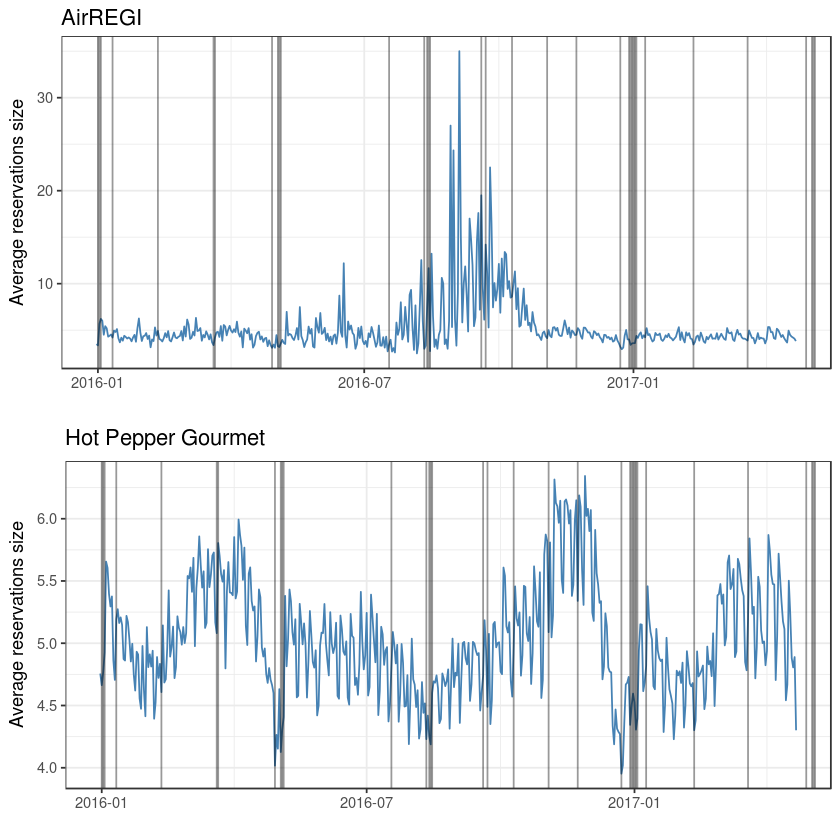

In [76]:
p1 <- air_res[, .(avg_size = sum(reserve_visitors) / .N), by = .(date = as.Date(reserve_datetime))] 

p1 <- ggplot(data = p1, aes(x = date, y = avg_size)) + 
    geom_line(color = 'steelblue') +
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    labs(x = '', y = 'Average reservations size', title = 'AirREGI')

p2 <- hpg_res[, .(avg_size = sum(reserve_visitors) / .N), by = .(date = as.Date(reserve_datetime))] 

p2 <- ggplot(data = p2, aes(x = date, y = avg_size)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    labs(x = '', y = 'Average reservations size', title = 'Hot Pepper Gourmet')

grid.arrange(p1, p2)

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


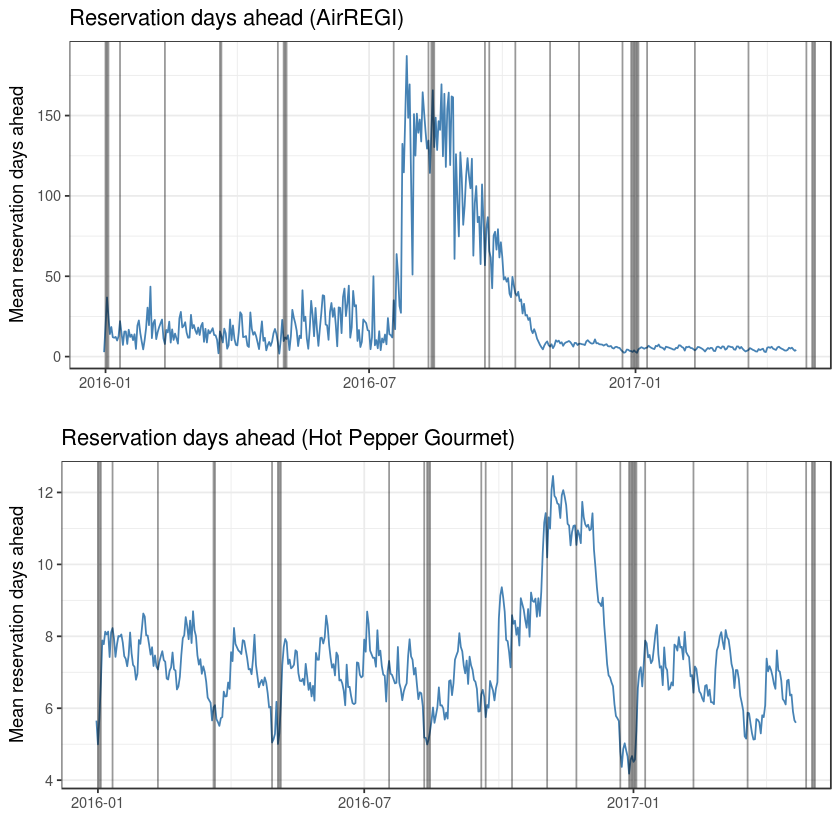

In [77]:
# calculate difference between reservation and visit
air_res[, res_diff := difftime(visit_datetime, reserve_datetime, units = 'days')]
hpg_res[, res_diff := difftime(visit_datetime, reserve_datetime, units = 'days')]

p1 <- air_res[, .(mean_res_diff = mean(res_diff)), by = .(date = as.Date(reserve_datetime))] 
p1 <- ggplot(data = p1, aes(x = date, y = mean_res_diff)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    labs(x = '', y = 'Mean reservation days ahead', title = 'Reservation days ahead (AirREGI)')

p2 <- hpg_res[, .(mean_res_diff = mean(res_diff)), by = .(date = as.Date(reserve_datetime))] 
p2 <- ggplot(data = p2, aes(x = date, y = mean_res_diff)) + 
    geom_line(color = 'steelblue') + 
    geom_vline(data = holidays, aes(xintercept = as.numeric(as.Date(calendar_date))), alpha = 0.4) + 
    labs(x = '', y = 'Mean reservation days ahead', title = 'Reservation days ahead (Hot Pepper Gourmet)')

grid.arrange(p1, p2)

In [78]:
# Stores
n_air <- length(unique(air_store$air_store_id))
n_hpg <- length(unique(hpg_store$hpg_store_id))

print(paste('The AirREGI data has', n_air, 'stores', 'and the Hot Pepper Gourmet data has', n_hpg, 'stores.'))

[1] "The AirREGI data has 829 stores and the Hot Pepper Gourmet data has 4690 stores."


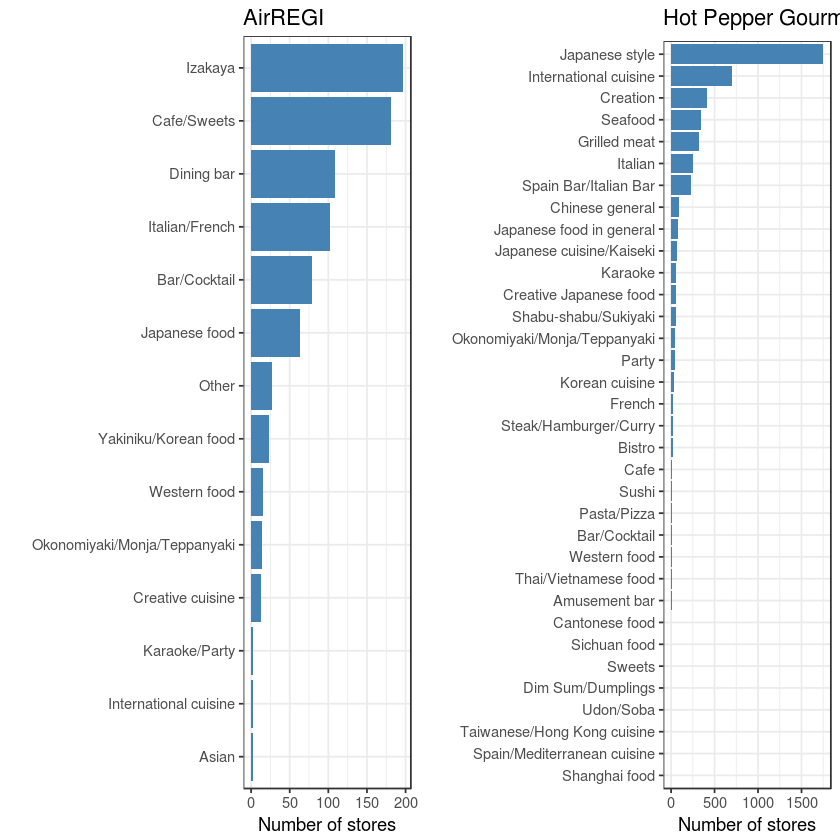

In [79]:
p1 <- air_store[, .N, by = air_genre_name] %>%
    ggplot(aes(x = reorder(air_genre_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'AirREGI') + 
    coord_flip()

p2 <- hpg_store[, .N, by = hpg_genre_name] %>%
    ggplot(aes(x = reorder(hpg_genre_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'Hot Pepper Gourmet') + 
    coord_flip()

grid.arrange(p1, p2, ncol = 2)

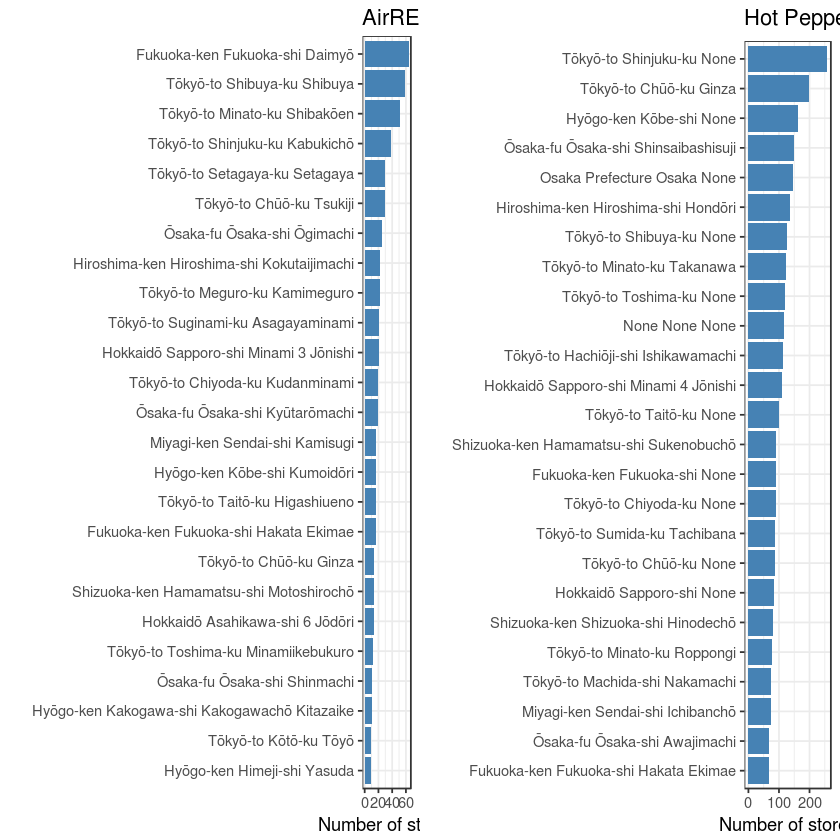

In [80]:
p1 <- air_store[, .N, by = air_area_name][order(N, decreasing = TRUE)] %>%
    head(25) %>%
    ggplot(aes(x = reorder(air_area_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'AirREGI') + 
    coord_flip()

p2 <- hpg_store[, .N, by = hpg_area_name][order(N, decreasing = TRUE)] %>%
    head(25) %>%
    ggplot(aes(x = reorder(hpg_area_name, N), y = N)) +
    geom_bar(stat = 'identity', fill = 'steelblue') +
    labs(x = '', y = 'Number of stores', title = 'Hot Pepper Gourmet') + 
    coord_flip()

grid.arrange(p1, p2, ncol = 2)

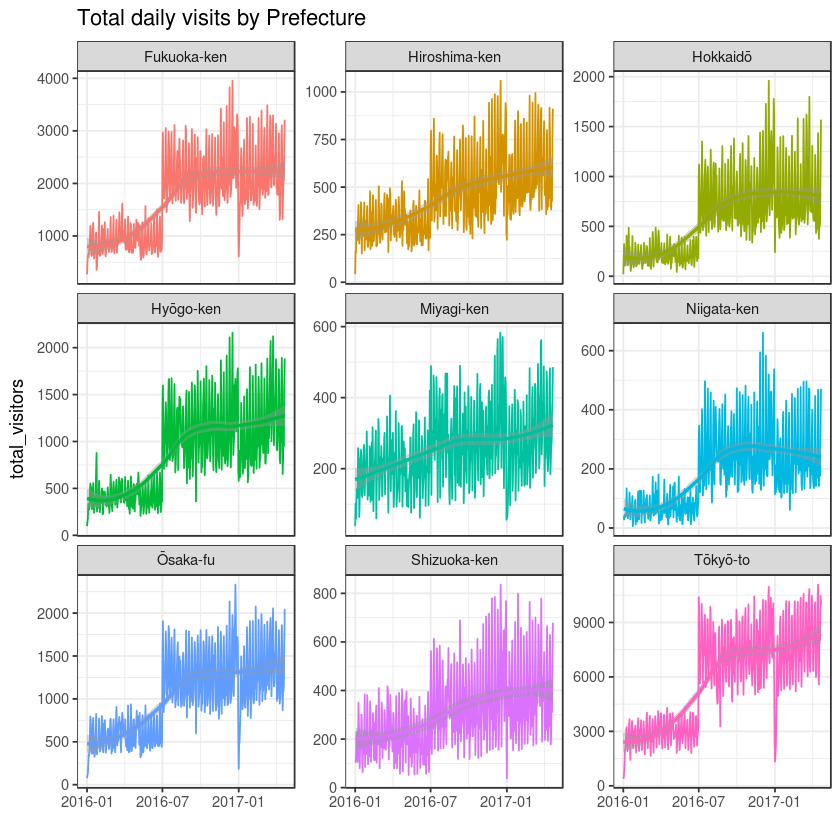

In [81]:
air_store[, pref := tstrsplit(air_area_name, split = " ", keep = 1)]
hpg_store[, pref := tstrsplit(hpg_area_name, split = " ", keep = 1)]

setkey(visits, air_store_id)
setkey(air_store, air_store_id)
setkey(hpg_store, hpg_store_id)

visits[air_store][, .(total_visitors = sum(visitors)), by = c('visit_date', 'pref')] %>%
    ggplot(aes(x = visit_date, y = total_visitors, color = pref)) + 
    geom_line() + 
    geom_smooth(method = 'loess') + 
    facet_wrap(~pref, scales = 'free_y') + 
    labs(x = '', title = 'Total daily visits by Prefecture') + 
    theme(legend.position = "none")

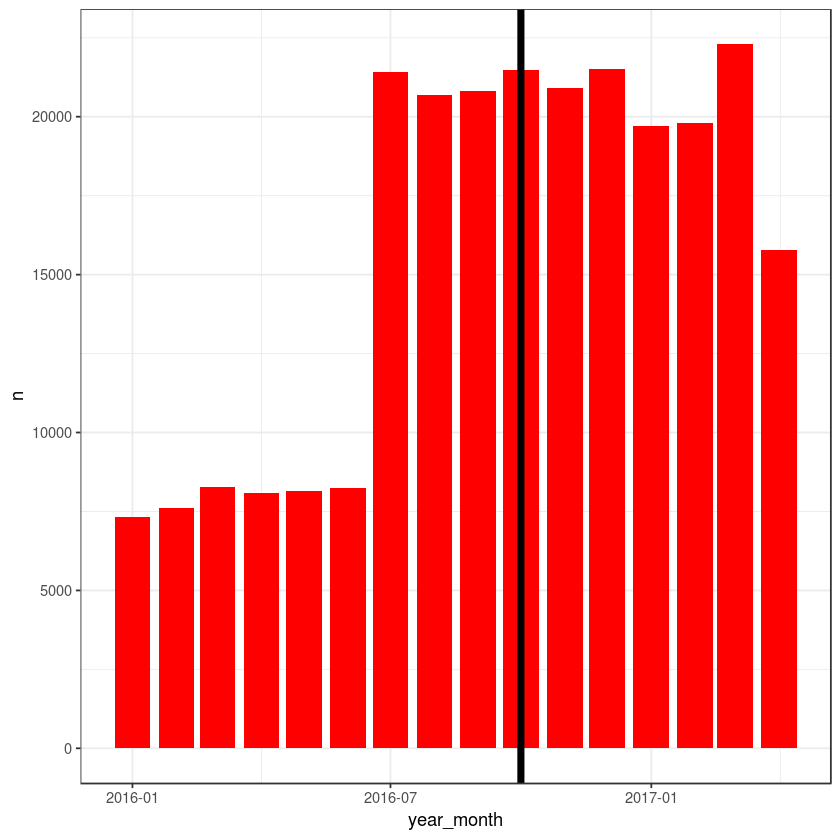

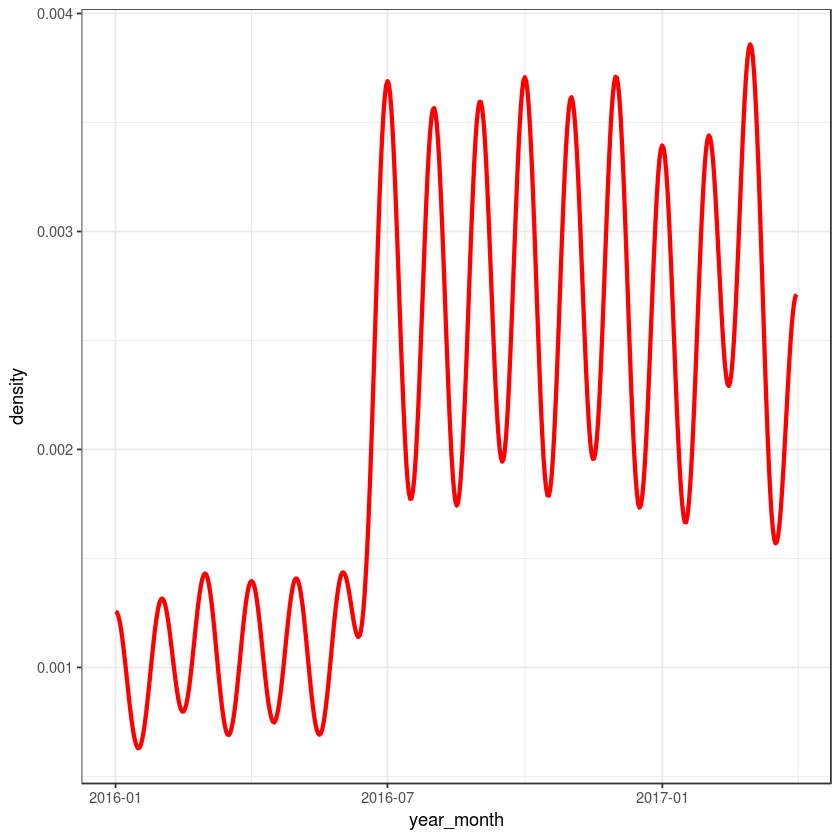

In [106]:
# Rename columns if required
# properties <- properties %>% rename(


tmp <- visits %>% mutate(year_month = make_date(year=year(visit_date),month=month(visit_date)))
tmp %>% 
  group_by(year_month) %>% count() %>% 
  ggplot(aes(x=year_month,y=n)) +
  geom_bar(stat="identity", fill="red")+
  geom_vline(aes(xintercept=as.numeric(as.Date("2016-10-01"))),size=2)

tmp %>% 
  ggplot(aes(x=year_month))+geom_line(stat="density", color="red", size=1.2)+theme_bw()


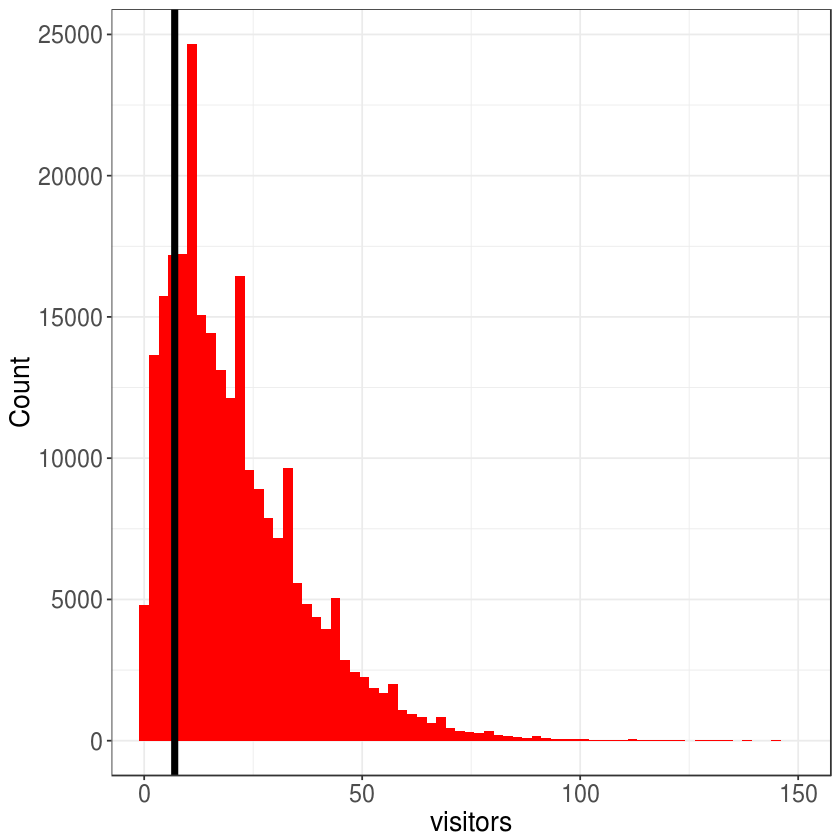

In [97]:
visits %>% 
  ggplot(aes(x=visitors)) + #abs(visitors) => absolute value checking
  geom_histogram(bins=400, fill="red")+
  geom_vline(aes(xintercept=7), size=2)+
  theme_bw()+theme(axis.title = element_text(size=16),axis.text = element_text(size=14))+
  ylab("Count")+coord_cartesian(x=c(0,150))

`geom_smooth()` using method = 'loess'


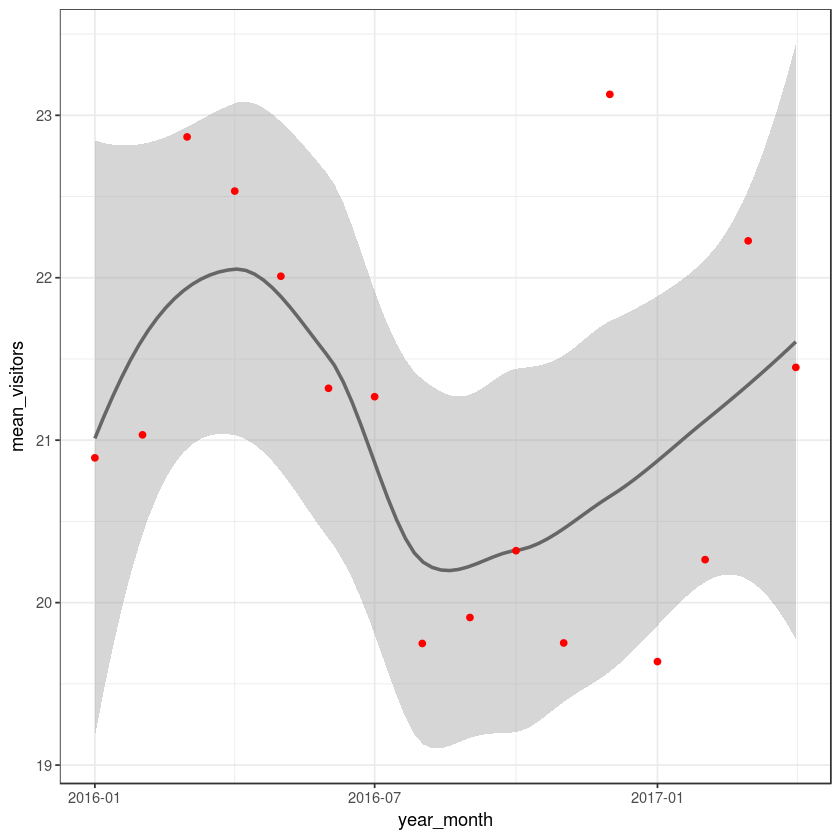

In [110]:
tmp %>% 
  group_by(year_month) %>% 
  summarize(mean_visitors = mean(abs(visitors)),n()) %>% 
  ggplot(aes(x=year_month,y=mean_visitors))+
  geom_smooth(color="grey40")+
  geom_point(color="red")+theme_bw()

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over all variables, use `summarise_all()`


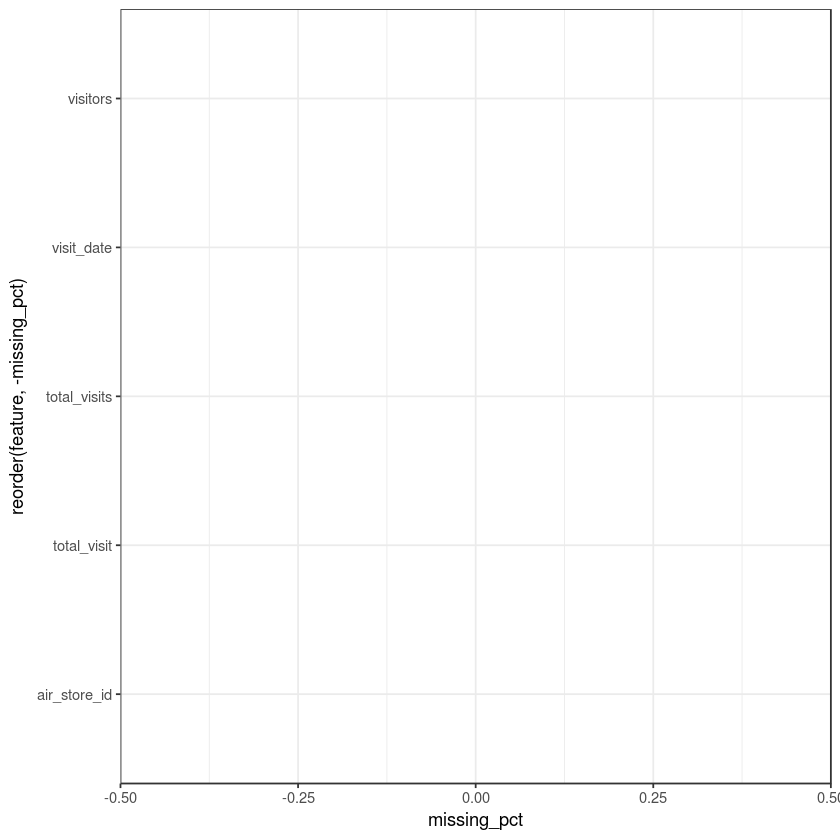

In [98]:
missing_values <- visits %>% summarize_each(funs(sum(is.na(.))/n()))

missing_values <- gather(missing_values, key="feature", value="missing_pct")
missing_values %>% 
  ggplot(aes(x=reorder(feature,-missing_pct),y=missing_pct)) +
  geom_bar(stat="identity",fill="red")+
  coord_flip()+theme_bw()

In [100]:
good_features <- filter(missing_values, missing_pct<0.75)
good_features

feature,missing_pct
air_store_id,0
visit_date,0
visitors,0
total_visits,0
total_visit,0


#Following does not work

corrplot 0.84 loaded


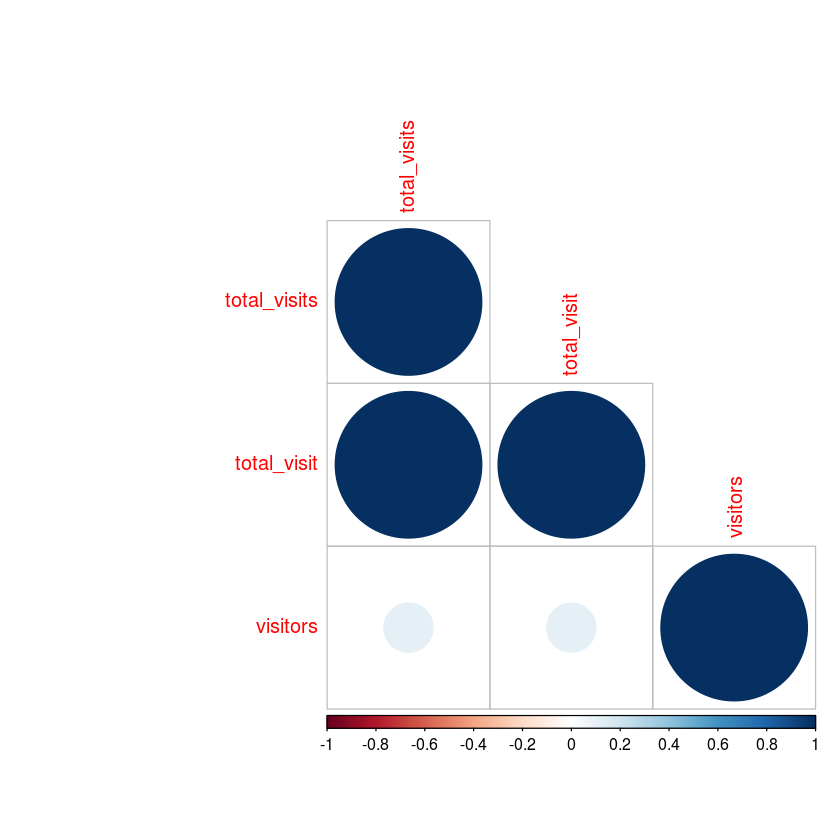

In [103]:
#correlation
library(corrplot)

vars <- c('total_visits','total_visit')
tmp <- visits %>% select(one_of(c(vars,"visitors")))

corrplot(cor(tmp, use="complete.obs"),type="lower")


In [83]:
# create the labels

library(plotly)

labels <- sprintf(
    "Store ID: %s</br>Prefecture:%s</br>Genre: %s", air_store$air_store_id, air_store$pref, air_store$air_genre_name) %>%
    lapply(HTML)

    leaflet(air_store) %>%    addCircleMarkers(radius = 4)

air_store %>%
    leaflet() %>%
    addProviderTiles("CartoDB.Positron") %>%
    addCircleMarkers(~ longitude,
    ~ latitude,
    radius = 4,
    label = labels,
    clusterOptions = markerClusterOptions())

embed_notebook(d)

Assuming 'longitude' and 'latitude' are longitude and latitude, respectively


HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)

ERROR: Error in UseMethod("embed_notebook"): no applicable method for 'embed_notebook' applied to an object of class "c('leaflet', 'htmlwidget')"


In [ ]:
# get the japan and prefecture shapes
japan_map <- map("japan", fill = TRUE, col = 1, plot = FALSE)

japan_map_ids <- sapply( strsplit( japan_map$names, ':' ), function(x) x[1] )

# convert to a SpatialPolygon
japan_sp <- map2SpatialPolygons(japan_map, IDs=japan_map_ids, proj4string=CRS("+proj=longlat +datum=WGS84"))

# get the names of the countries from japan_sp
tmp_id_df <- data.frame(ID = names(japan_sp))

# make the rownames the prefecture name as well
rownames(tmp_id_df) <- names(japan_sp)

# make the SpatialPolygonDataFrame
japan_spdf <- SpatialPolygonsDataFrame(japan_sp, tmp_id_df)


hpg_store[, pref := gsub('-ken', '', pref)]
hpg_store[, pref := gsub('-fu', '', pref)]
hpg_store[, pref := gsub('-to', '', pref)]
hpg_store[, pref := chartr('Ōō', 'Oo', pref)]
store_counts <- hpg_store[, .N, by = pref]

# merge with the spatial dataframe by prefecture name
dd <- merge(japan_spdf, store_counts, by.x = 'ID', by.y = 'pref')

# create the choropleth palette
bins <- c(0, 50, 100, 200, 500, 1000, 2000, Inf)
pal <- colorBin("YlOrRd", domain = dd$density, bins = bins)

# create the prefecture labels
labels <- sprintf(
    "%s</br>Number of stores: %g", dd$ID, dd$N) %>%
    lapply(HTML)

# build the map
leaflet(dd) %>%
    addProviderTiles("CartoDB.Positron") %>%
    addPolygons(data = dd, weight = 1, fillColor = ~pal(dd$N), fillOpacity = 0.5,
                    highlight = highlightOptions(
                        weight = 5,
                        color = "#666",
                        dashArray = "",
                        fillOpacity = 0.7,
                    bringToFront = TRUE),
                    label = labels) %>%
    addLegend(pal = pal, values = ~ N, opacity = 0.7, title = NULL, position = 'bottomright')

In [ ]:
library(maps)
mapStates = map("state", fill = TRUE, plot = FALSE)
m = leaflet(data = mapStates) 

m = addTiles(m) 
m %>%addPolygons(fillColor = topo.colors(10, alpha = NULL), stroke = FALSE)



In [ ]:
#get some Violin + boxplots